In [ ]:
'''
This script scrapes the IMDb Top 250 movies and extracts details such as title, year, rating, genre, director, actors, and box office revenue. 
The data is then saved to a CSV file for further analysis.
'''
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Set up the WebDriver options
options = Options()
options.add_argument("--headless")  # Run in headless mode
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

# Initialize WebDriver
service = Service("C:\\Users\\ASUS\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

# IMDb Top 250 URL
top_250_url = "https://www.imdb.com/chart/top/"

# Open the URL
driver.get(top_250_url)

# Wait for the page to load and movie links to appear
WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "ul.ipc-metadata-list li")))

# Parse HTML with BeautifulSoup
soup = BeautifulSoup(driver.page_source, "html.parser")
print(driver.page_source[:1000])  # Prints the first 1000 characters of the page source

# Extract movie links
movies = soup.select("ul.ipc-metadata-list li a.ipc-title-link-wrapper")
movie_links = ["https://www.imdb.com" + movie["href"] for movie in movies]

# Limit to first 250 movies
movie_links = movie_links[:250]
print(f"Scraping {len(movie_links)} movie links...")
print(movie_links[:250])  # Display the first 250 links

# Initialize list for data
movies_data = []

# Loop through each movie link
for index, link in enumerate(movie_links):
    driver.get(link)
    time.sleep(1)  # Allow page to load
    
    # Wait for the title to load on the movie page
    WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, "h1")))

    movie_soup = BeautifulSoup(driver.page_source, "html.parser")

    # Extract movie details
    try:
        # Title
        title = movie_soup.find("h1").text.strip() if movie_soup.find("h1") else "N/A"

        # Year
        year = movie_soup.select_one("ul.ipc-inline-list li a[href*='releaseinfo']").text.strip() if movie_soup.select_one("ul.ipc-inline-list li a[href*='releaseinfo']") else "N/A"

        # Rating (wait for dynamic content)
        try:
            # Wait for the rating to be fully visible
            rating_element = WebDriverWait(driver, 10).until(
                EC.visibility_of_element_located((By.CSS_SELECTOR, "span.sc-d541859f-1.imUuxf"))
            )
            rating = rating_element.text.strip()
        except Exception as e:
            print(f"Error finding rating: {e}")
            rating = "N/A"


        # Genres
        genre_tags = movie_soup.select("div.ipc-chip-list a span")
        genres = ", ".join([g.text for g in genre_tags]) if genre_tags else "N/A"

        # Directors
        # Wait for the director's element to be visible
        try:
            director_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "div.sc-70a366cc-3.iwmAOx > div > ul > li:nth-child(1) > div > ul > li > a"))
            )
            
            # Get the current director's name
            current_director = director_element.text.strip()
            print(f"Current Director: {current_director}")

            # Modify the director's name (for testing, we use JavaScript)
            driver.execute_script("arguments[0].innerText = 'New Director Name';", director_element)

            print("✅ Director's name edited successfully!")

        except Exception as e:
            print(f"Error locating director: {e}")

    
        # Wait for actors section to be present
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.sc-70a366cc-3.iwmAOx > div > ul > li:nth-child(3) > div > ul > li > a"))
            )

            # Extract actor names using BeautifulSoup
            actor_elements = driver.find_elements(By.XPATH, "//li[contains(@class, 'ipc-metadata-list__item')][3]//ul/li/a")
            actors = ", ".join([actor.text.strip() for actor in actor_elements[:3]]) if actor_elements else "N/A"


            print(f"🎭 Lead Actors: {actors}")

        except Exception as e:
            print(f"❌ Error extracting actors: {e}")

        
        # Box office revenue (optional)
        try:
            # Wait for the box office section to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//li[contains(@class, 'ipc-metadata-list__item')]//span[contains(text(), 'Gross worldwide')]"))
            )

            # Find the label "Gross worldwide"
            box_office_label = driver.find_element(By.XPATH, "//li[contains(@class, 'ipc-metadata-list__item')]//span[contains(text(), 'Gross worldwide')]")
            
            # Extract the revenue value next to the label
            box_office_value = box_office_label.find_element(By.XPATH, "./following-sibling::div//span").text.strip()
            box_office = box_office_value

            print(f"💰 Box Office Revenue: {box_office}")

        except Exception as e:
            print(f"❌ Error extracting revenue: {e}")
            box_office = "N/A"


        # Save data
        movies_data.append({
            "Title": title,
            "Year": year,
            "IMDb Rating": rating,
            "Genre": genres,
            "Director(s)": current_director,
            "Lead Actors": actors,
            "Box Office Revenue": box_office
        })

        print(f"Scraped {index+1}: {title} ({year}) - Rating: {rating}")

    except Exception as e:
        print(f"Error scraping movie {index+1}: {e}")

# Close the Selenium driver
driver.quit()

# Save to CSV
df = pd.DataFrame(movies_data)
df.to_csv("imdb_top_250.csv", index=False)

print("\n✅ IMDb Top 250 Movies Scraped Successfully! Data saved to 'imdb_top_250.csv'")

<html lang="en-US" xmlns:og="http://opengraphprotocol.org/schema/" xmlns:fb="http://www.facebook.com/2008/fbml" class=" scriptsOn"><head><script async="" src="https://images-na.ssl-images-amazon.com/images/I/216YVwoRFDL.js" crossorigin="anonymous"></script><meta charset="utf-8"><meta name="viewport" content="width=device-width"><script>if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }</script><title>IMDb Top 250 Movies</title><meta name="description" content="As rated by regular IMDb voters." data-id="main"><meta name="robots" content="max-image-preview:large"><meta property="og:url" content="https://www.imdb.com/chart/top/"><meta property="og:site_name" content="IMDb"><meta property="og:title" content="IMDb Top 250 Movies"><meta property="og:description" content="As rated by regular IMDb voters."><meta property="og:type" content="website"><meta property="og:image" content="https://m.media-amazon.com/images/G/01/imdb/images/social/imdb_logo.png"><meta property="og:image

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv("imdb_top_250.csv")

# Display the first few rows
print(df.head())

print(df.info())

                      Title  Year  IMDb Rating  \
0  The Shawshank Redemption  1994          9.3   
1             The Godfather  1972          9.2   
2           The Dark Knight  2008          9.0   
3     The Godfather Part II  1974          9.0   
4              12 Angry Men  1957          9.0   

                                               Genre           Director(s)  \
0            Epic, Period Drama, Prison Drama, Drama        Frank Darabont   
1              Epic, Gangster, Tragedy, Crime, Drama  Francis Ford Coppola   
2  Action Epic, Epic, Superhero, Tragedy, Action,...     Christopher Nolan   
3              Epic, Gangster, Tragedy, Crime, Drama  Francis Ford Coppola   
4     Legal Drama, Psychological Drama, Crime, Drama          Sidney Lumet   

                                   Lead Actors Box Office Revenue  
0      Tim Robbins, Morgan Freeman, Bob Gunton        $29,332,133  
1         Marlon Brando, Al Pacino, James Caan       $250,342,198  
2  Christian Bale, Heath L

In [3]:
# Clean the Box Office Revenue column
df['Box Office Revenue'] = df['Box Office Revenue'].replace('[\$,]', '', regex=True).replace('N/A', pd.NA).astype(float)

# Clean the IMDb Rating column
df['IMDb Rating'] = df['IMDb Rating'].replace('N/A', pd.NA).astype(float)

# Clean the Year column
df['Year'] = df['Year'].replace('N/A', pd.NA).astype(float)

# Drop rows with missing values
df = df.dropna()

# Display cleaned data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 0 to 248
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               246 non-null    object 
 1   Year                246 non-null    float64
 2   IMDb Rating         246 non-null    float64
 3   Genre               246 non-null    object 
 4   Director(s)         246 non-null    object 
 5   Lead Actors         246 non-null    object 
 6   Box Office Revenue  246 non-null    float64
dtypes: float64(3), object(4)
memory usage: 15.4+ KB
None


In [4]:
# Descriptive statistics for IMDb Rating
rating_stats = df['IMDb Rating'].describe()
print("IMDb Rating Statistics:")
print(rating_stats)

# Descriptive statistics for Box Office Revenue
revenue_stats = df['Box Office Revenue'].describe()
print("\nBox Office Revenue Statistics:")
print(revenue_stats)

# Descriptive statistics for Year
year_stats = df['Year'].describe()
print("\nYear Statistics:")
print(year_stats)

IMDb Rating Statistics:
count    246.000000
mean       8.309350
std        0.232717
min        8.000000
25%        8.100000
50%        8.200000
75%        8.400000
max        9.300000
Name: IMDb Rating, dtype: float64

Box Office Revenue Statistics:
count    2.460000e+02
mean     2.297103e+08
std      3.710648e+08
min      3.990000e+02
25%      7.535690e+06
50%      6.251449e+07
75%      3.216797e+08
max      2.799439e+09
Name: Box Office Revenue, dtype: float64

Year Statistics:
count     246.000000
mean     1987.939024
std        25.510469
min      1921.000000
25%      1971.250000
50%      1995.000000
75%      2008.000000
max      2024.000000
Name: Year, dtype: float64


In [5]:
# Group by Year and calculate mean revenue and rating
trends = df.groupby('Year').agg({
    'Box Office Revenue': 'mean',
    'IMDb Rating': 'mean'
}).reset_index()

# Display trends
print(trends)

      Year  Box Office Revenue  IMDb Rating
0   1921.0        4.197900e+04     8.200000
1   1924.0        3.990000e+02     8.200000
2   1925.0        3.149000e+04     8.100000
3   1926.0        1.344000e+03     8.100000
4   1927.0        1.350322e+06     8.300000
..     ...                 ...          ...
80  2020.0        2.404894e+07     8.200000
81  2021.0        9.763998e+08     8.350000
82  2022.0        1.495696e+09     8.200000
83  2023.0        5.555915e+08     8.533333
84  2024.0        2.708448e+08     8.375000

[85 rows x 3 columns]


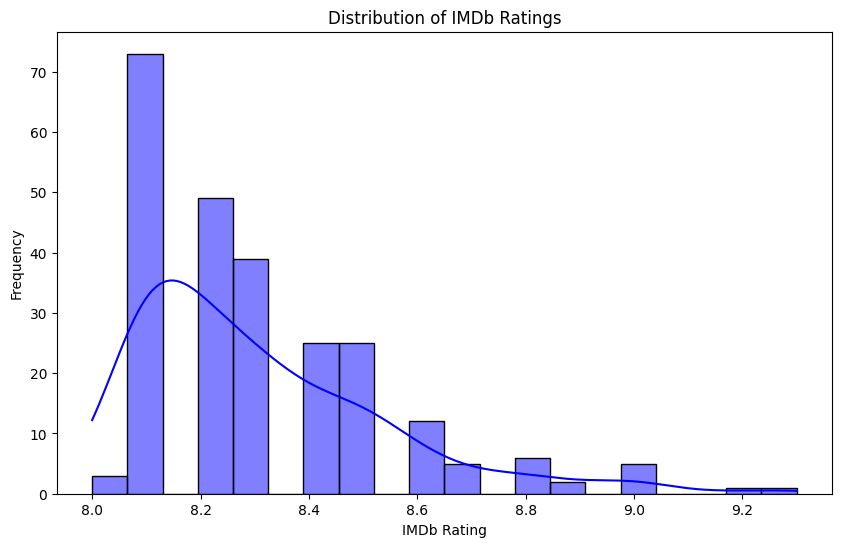

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of IMDb Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['IMDb Rating'], bins=20, kde=True, color='blue')
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.show()

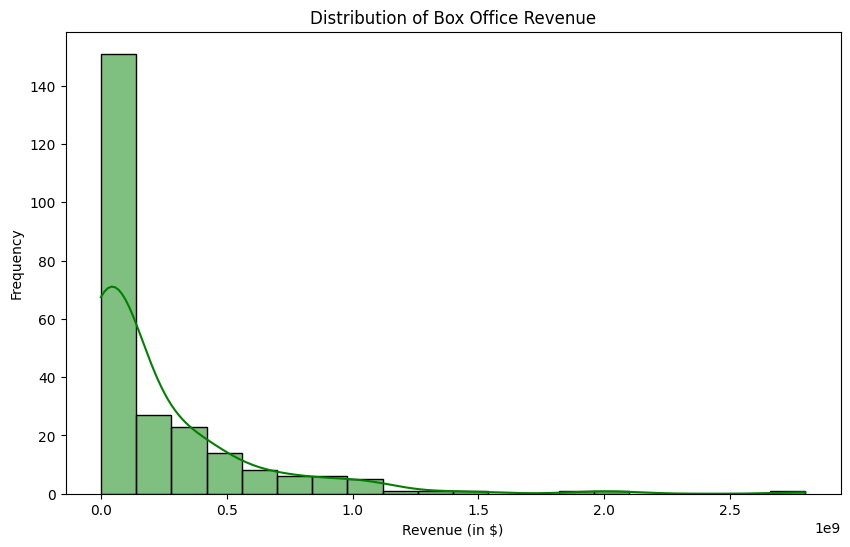

In [7]:
# Histogram of Box Office Revenue
plt.figure(figsize=(10, 6))
sns.histplot(df['Box Office Revenue'], bins=20, kde=True, color='green')
plt.title("Distribution of Box Office Revenue")
plt.xlabel("Revenue (in $)")
plt.ylabel("Frequency")
plt.show()

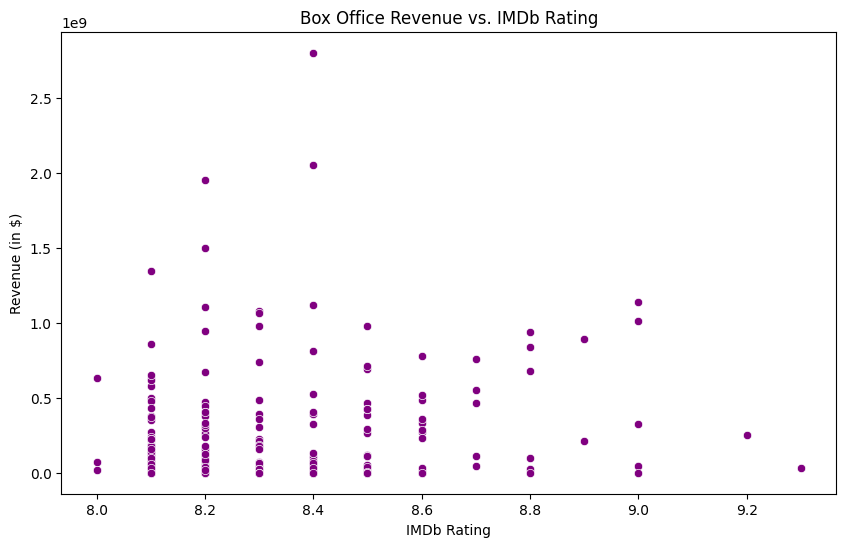

In [8]:
# Scatter plot of Revenue vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IMDb Rating', y='Box Office Revenue', data=df, color='purple')
plt.title("Box Office Revenue vs. IMDb Rating")
plt.xlabel("IMDb Rating")
plt.ylabel("Revenue (in $)")
plt.show()

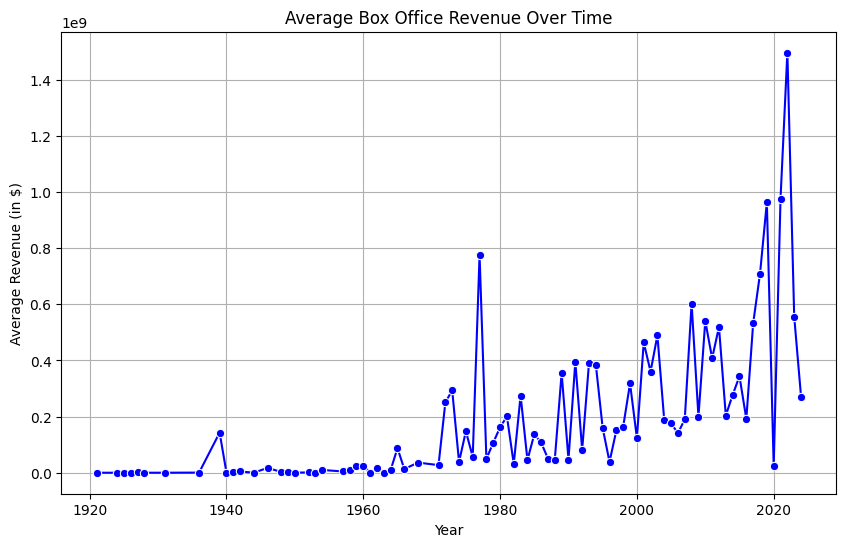

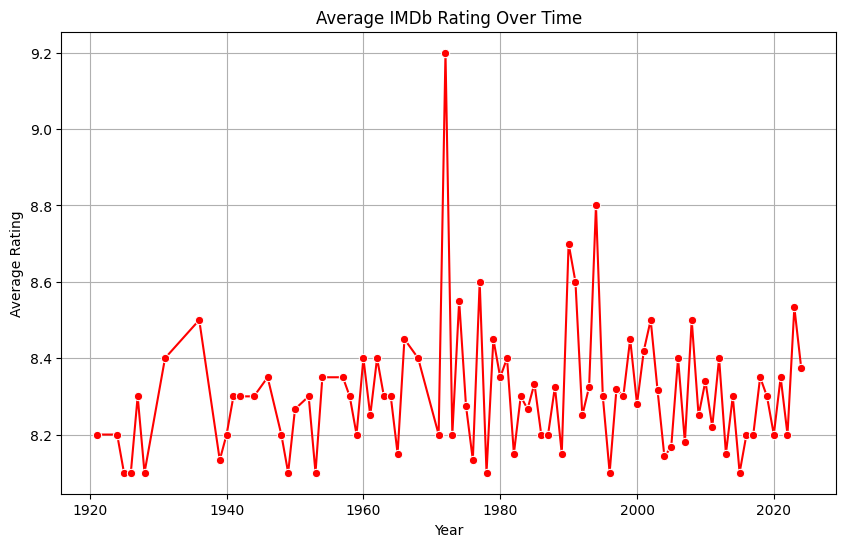

In [9]:
# Group by Year and calculate mean revenue and rating
trends = df.groupby('Year').agg({
    'Box Office Revenue': 'mean',
    'IMDb Rating': 'mean'
}).reset_index()

# Line plot for average revenue over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Box Office Revenue', data=trends, marker='o', color='blue')
plt.title("Average Box Office Revenue Over Time")
plt.xlabel("Year")
plt.ylabel("Average Revenue (in $)")
plt.grid(True)
plt.show()

# Line plot for average rating over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='IMDb Rating', data=trends, marker='o', color='red')
plt.title("Average IMDb Rating Over Time")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

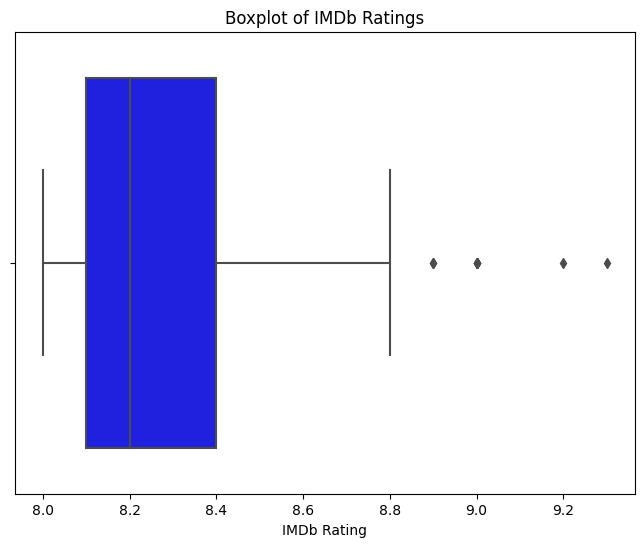

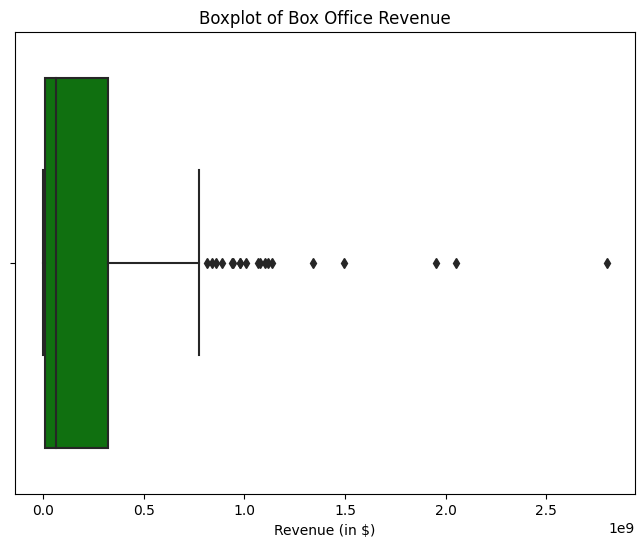

In [10]:
# Boxplot for IMDb Ratings
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['IMDb Rating'], color='blue')
plt.title("Boxplot of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.show()

# Boxplot for Box Office Revenue
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Box Office Revenue'], color='green')
plt.title("Boxplot of Box Office Revenue")
plt.xlabel("Revenue (in $)")
plt.show()

c:\Users\ASUS\Lasitha\MSC Data Science\Programming for DS\Assignment\EDA-For-IMDbFilms\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


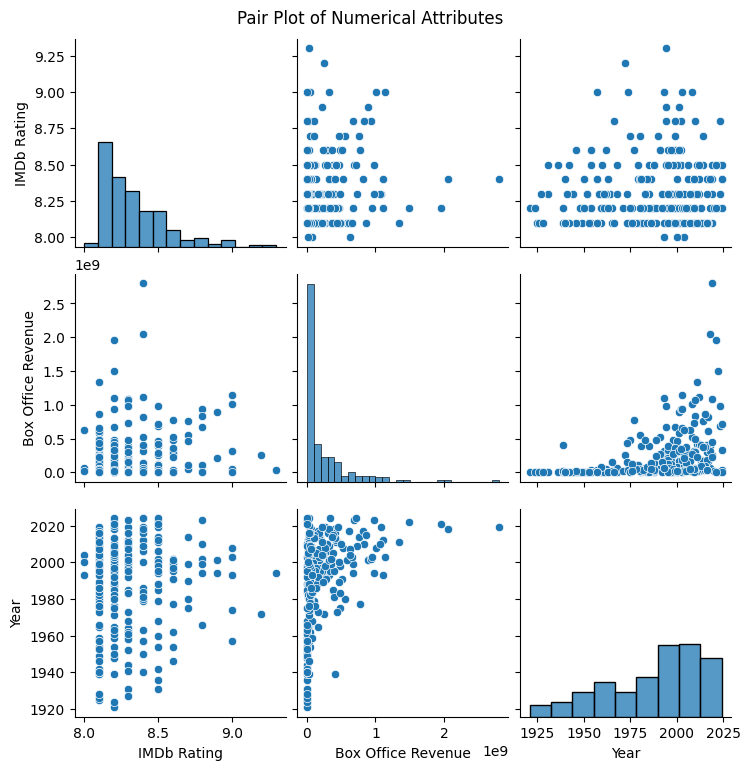

In [11]:
# Pair plot
sns.pairplot(df[['IMDb Rating', 'Box Office Revenue', 'Year']])
plt.suptitle("Pair Plot of Numerical Attributes", y=1.02)
plt.show()

Top 10 Directors by Number of Movies:
Director(s)
Christopher Nolan    8
Stanley Kubrick      7
Steven Spielberg     7
Martin Scorsese      7
Alfred Hitchcock     6
Akira Kurosawa       6
Charles Chaplin      5
Billy Wilder         5
Quentin Tarantino    5
Sergio Leone         4
Name: count, dtype: int64


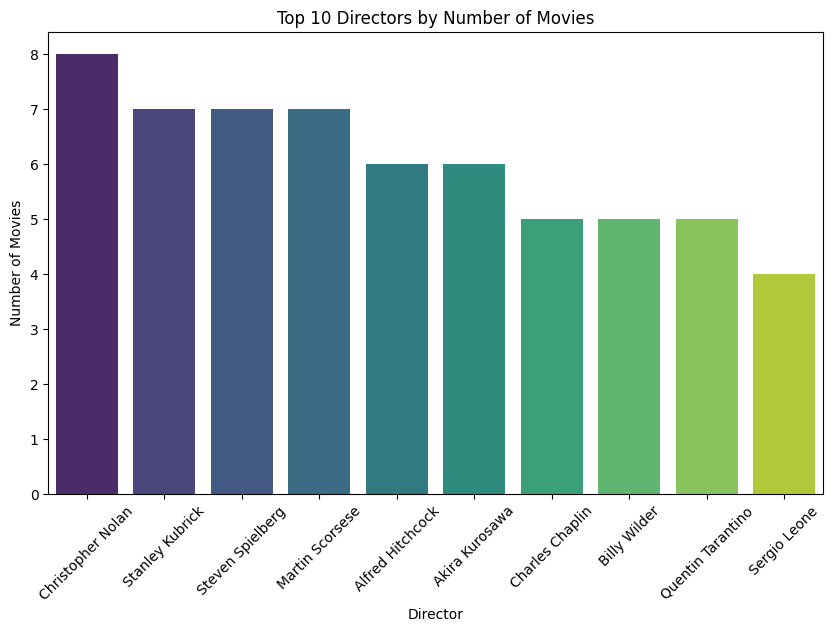

In [12]:
# Count movies by director
director_counts = df['Director(s)'].value_counts().head(10)
print("Top 10 Directors by Number of Movies:")
print(director_counts)

# Bar plot of top directors
plt.figure(figsize=(10, 6))
sns.barplot(x=director_counts.index, y=director_counts.values, palette='viridis')
plt.title("Top 10 Directors by Number of Movies")
plt.xlabel("Director")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()


Top 10 Directors by Average Revenue:
Director(s)
Anthony Russo      2.425927e+09
Jon Watts          1.952732e+09
Joseph Kosinski    1.495696e+09
David Yates        1.342500e+09
Todd Phillips      1.078959e+09
Peter Jackson      9.882275e+08
Roger Allers       9.791614e+08
Lee Unkrich        9.409786e+08
George Lucas       7.753985e+08
Andrew Stanton     7.345208e+08
Name: Box Office Revenue, dtype: float64


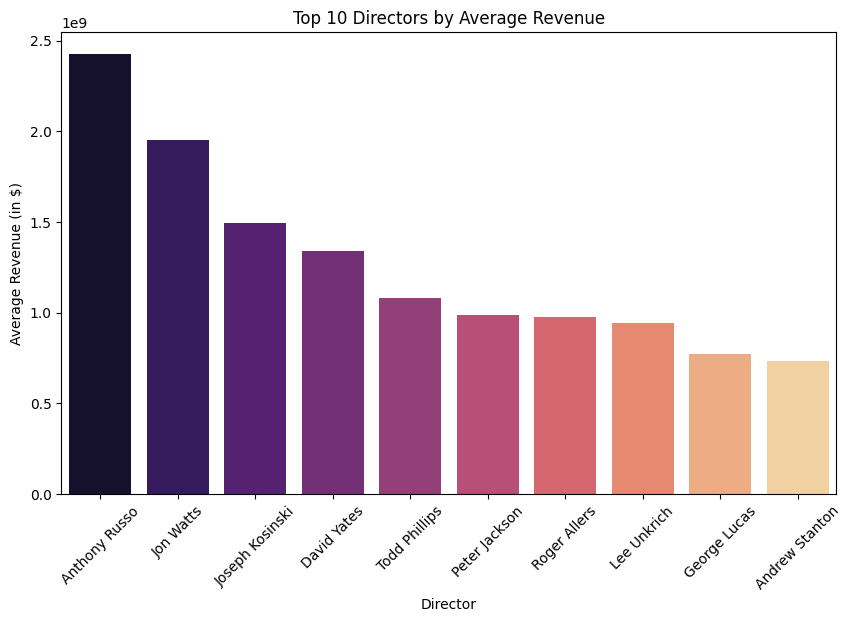

In [13]:
# Group by director and calculate average revenue
director_revenue = df.groupby('Director(s)')['Box Office Revenue'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 Directors by Average Revenue:")
print(director_revenue)

# Bar plot of top directors by average revenue
plt.figure(figsize=(10, 6))
sns.barplot(x=director_revenue.index, y=director_revenue.values, palette='magma')
plt.title("Top 10 Directors by Average Revenue")
plt.xlabel("Director")
plt.ylabel("Average Revenue (in $)")
plt.xticks(rotation=45)
plt.show()

Top 10 Actors by Number of Movies:
Robert De Niro       9
Harrison Ford        6
Leonardo DiCaprio    6
Tom Hanks            6
Clint Eastwood       5
Charles Chaplin      5
Christian Bale       5
Matt Damon           5
James Stewart        4
Toshirô Mifune       4
Name: count, dtype: int64


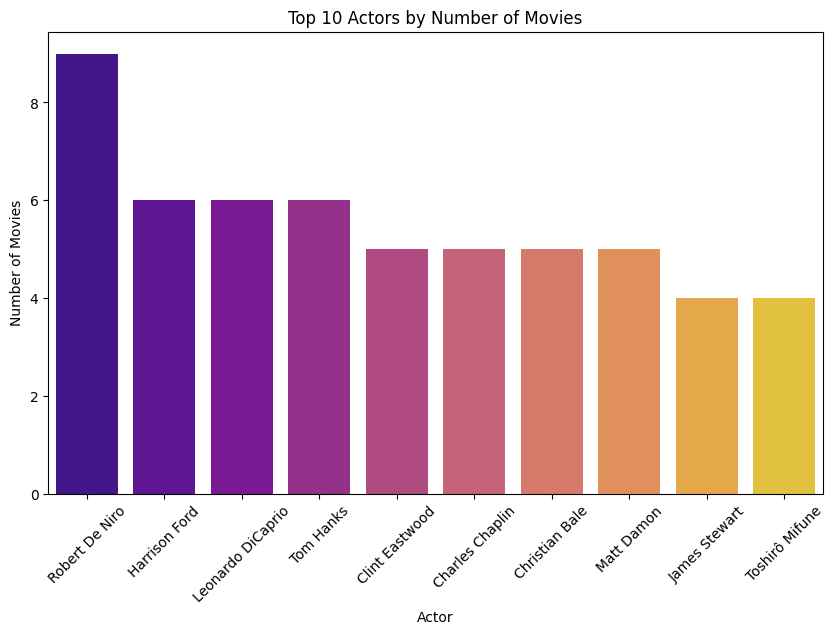

In [14]:
# Split actors and count their appearances
actors = df['Lead Actors'].str.split(', ', expand=True).stack()
actor_counts = actors.value_counts().head(10)
print("Top 10 Actors by Number of Movies:")
print(actor_counts)

# Bar plot of top actors
plt.figure(figsize=(10, 6))
sns.barplot(x=actor_counts.index, y=actor_counts.values, palette='plasma')
plt.title("Top 10 Actors by Number of Movies")
plt.xlabel("Actor")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()


Top 10 Actors by Average Revenue:
Lead Actors
Robert Downey Jr., Chris Evans, Mark Ruffalo        2.799439e+09
Robert Downey Jr., Chris Hemsworth, Mark Ruffalo    2.052415e+09
Tom Holland, Zendaya, Benedict Cumberbatch          1.952732e+09
Tom Cruise, Jennifer Connelly, Miles Teller         1.495696e+09
Daniel Radcliffe, Emma Watson, Rupert Grint         1.342500e+09
Elijah Wood, Viggo Mortensen, Ian McKellen          1.138268e+09
Christian Bale, Tom Hardy, Anne Hathaway            1.114976e+09
Sam Neill, Laura Dern, Jeff Goldblum                1.104380e+09
Joaquin Phoenix, Robert De Niro, Zazie Beetz        1.078959e+09
Tom Hanks, Tim Allen, Joan Cusack                   1.067316e+09
Name: Box Office Revenue, dtype: float64


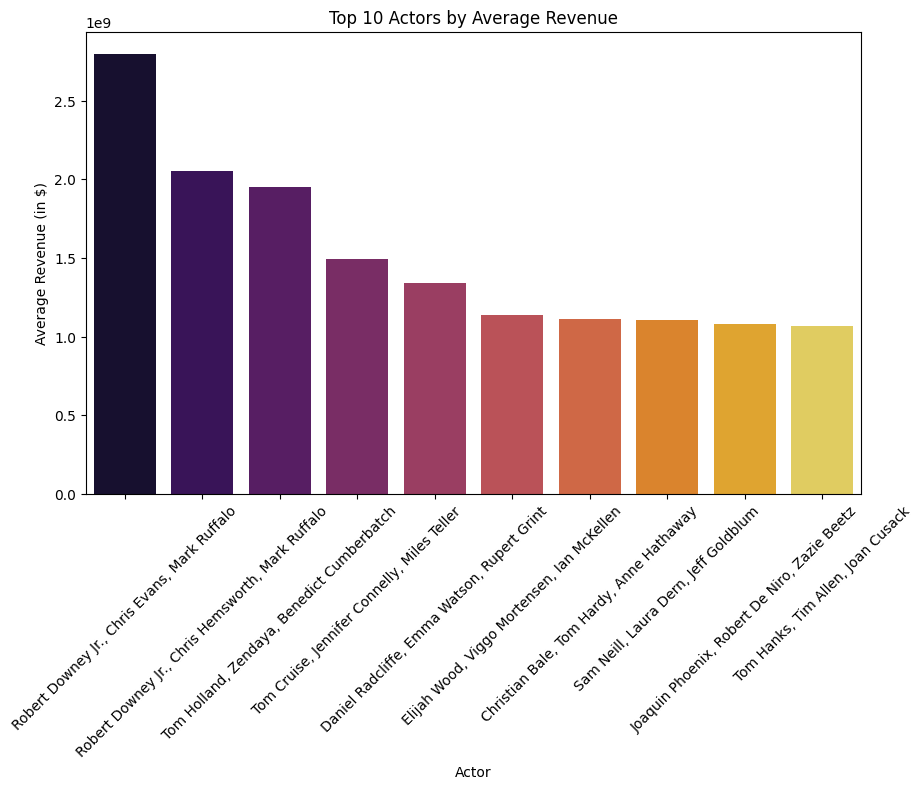

In [15]:
# Group by actor and calculate average revenue
actor_revenue = df.groupby('Lead Actors')['Box Office Revenue'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 Actors by Average Revenue:")
print(actor_revenue)

# Bar plot of top actors by average revenue
plt.figure(figsize=(10, 6))
sns.barplot(x=actor_revenue.index, y=actor_revenue.values, palette='inferno')
plt.title("Top 10 Actors by Average Revenue")
plt.xlabel("Actor")
plt.ylabel("Average Revenue (in $)")
plt.xticks(rotation=45)
plt.show()

Top 10 Directors by IMDb Rating:
                      IMDb Rating  Box Office Revenue
Director(s)                                          
Frank Darabont           8.950000        1.580668e+08
Peter Jackson            8.900000        9.882275e+08
Francis Ford Coppola     8.866667        1.344642e+08
Vidhu Vinod Chopra       8.800000        1.382880e+05
Lana Wachowski           8.700000        4.678417e+08
Irvin Kershner           8.700000        5.500161e+08
Robert Zemeckis          8.650000        5.316399e+08
George Lucas             8.600000        7.753985e+08
Masaki Kobayashi         8.600000        1.522200e+04
Fernando Meirelles       8.600000        3.068103e+07


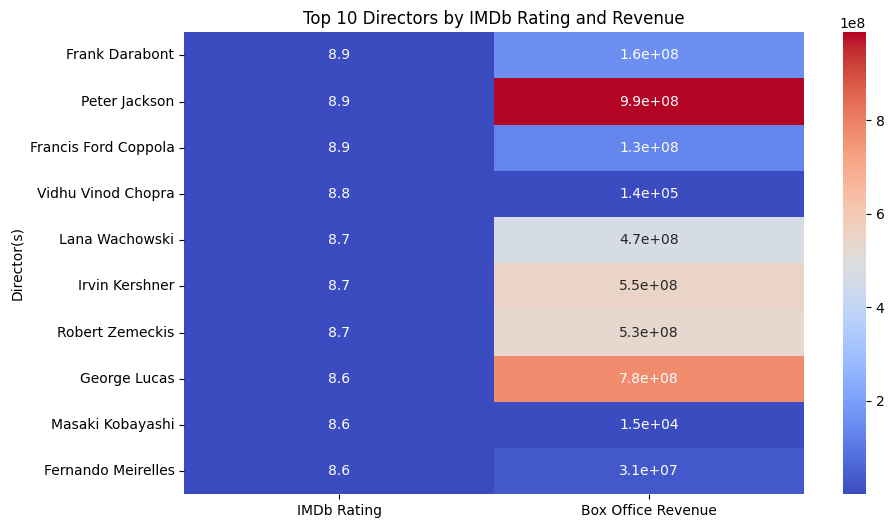

In [17]:
# Group by director and calculate average rating and revenue
director_influence = df.groupby('Director(s)').agg({
    'IMDb Rating': 'mean',
    'Box Office Revenue': 'mean'
}).sort_values(by='IMDb Rating', ascending=False).head(10)

print("Top 10 Directors by IMDb Rating:")
print(director_influence)

# Heatmap of director influence
plt.figure(figsize=(10, 6))
sns.heatmap(director_influence, annot=True, cmap='coolwarm')
plt.title("Top 10 Directors by IMDb Rating and Revenue")
plt.show()

Top 10 Genres by Number of Movies:
Index(['Drama', 'Adventure', 'Epic', 'Thriller', 'Period Drama', 'Crime',
       'Tragedy', 'Action', 'Psychological Drama', 'Comedy'],
      dtype='object', name='Genre')
Genre Counts Over Time (Top 10 Genres):
Genre   Action  Adventure  Comedy  Crime  Drama  Epic  Period Drama  \
Year                                                                  
1921.0     0.0        0.0     1.0    0.0    1.0   0.0           0.0   
1924.0     1.0        0.0     1.0    0.0    0.0   0.0           0.0   
1925.0     0.0        1.0     1.0    0.0    1.0   0.0           0.0   
1926.0     1.0        1.0     1.0    0.0    1.0   0.0           0.0   
1927.0     0.0        0.0     0.0    0.0    1.0   1.0           0.0   

Genre   Psychological Drama  Thriller  Tragedy  
Year                                            
1921.0                  0.0       0.0      0.0  
1924.0                  0.0       0.0      0.0  
1925.0                  0.0       0.0      0.0  
1926.0    

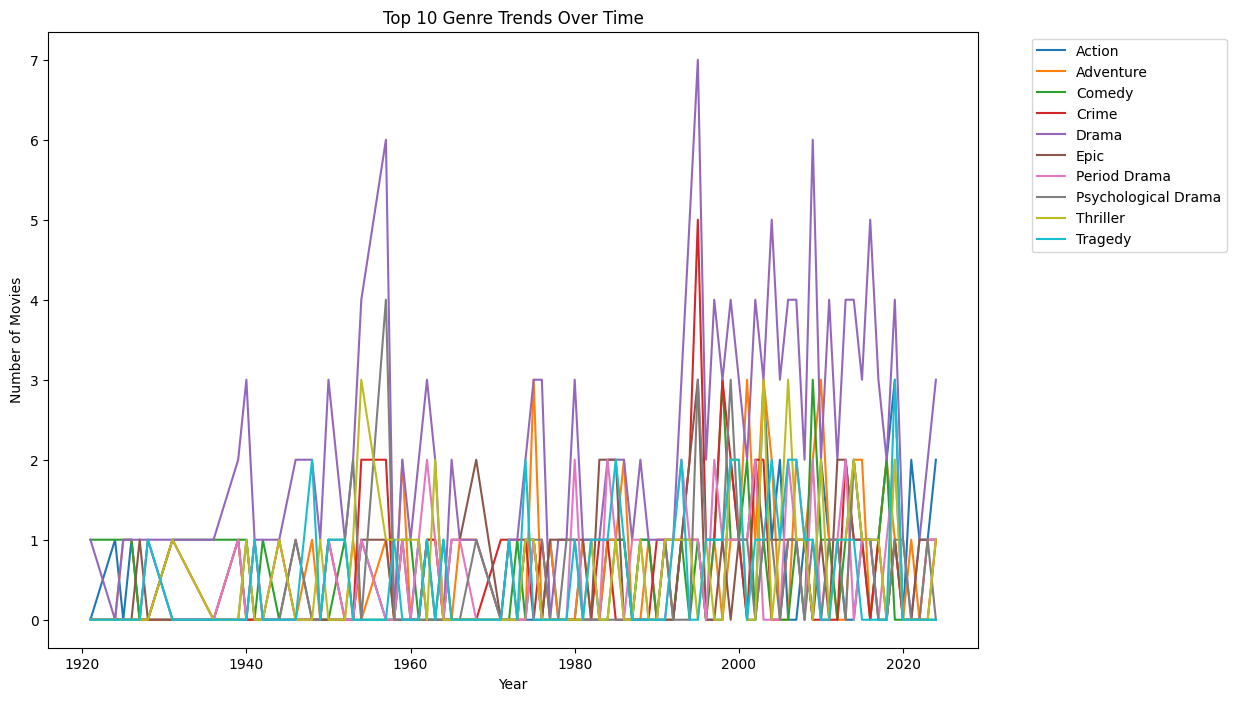

In [25]:
# Split genres and count their appearances
df_exploded = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')

# Count occurrences of each genre
genre_counts_total = df_exploded['Genre'].value_counts()

# Get the top 10 genres
top_10_genres = genre_counts_total.head(10).index

print("Top 10 Genres by Number of Movies:")
print(top_10_genres)

# Filter for top 10 genres
df_top_10_genres = df_exploded[df_exploded['Genre'].isin(top_10_genres)]

# Group by Year and Genre, then count occurrences
genre_counts = df_top_10_genres.groupby(['Year', 'Genre']).size().unstack().fillna(0)

print("Genre Counts Over Time (Top 10 Genres):")
print(genre_counts.head())

# Plot genre trends over time for top 10 genres
plt.figure(figsize=(12, 8))
for genre in genre_counts.columns:
    sns.lineplot(x=genre_counts.index, y=genre_counts[genre], label=genre)
plt.title("Top 10 Genre Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Average Box Office Revenue by Genre:
Genre
Mountain Adventure    1.138268e+09
Dinosaur Adventure    1.104380e+09
Superhero             1.070364e+09
Time Travel           9.078214e+08
Space Sci-Fi          7.491722e+08
Jungle Adventure      7.035809e+08
Teen Adventure        7.029951e+08
Fantasy Epic          7.012466e+08
Sea Adventure         6.912730e+08
Urban Adventure       6.859773e+08
Name: Box Office Revenue, dtype: float64


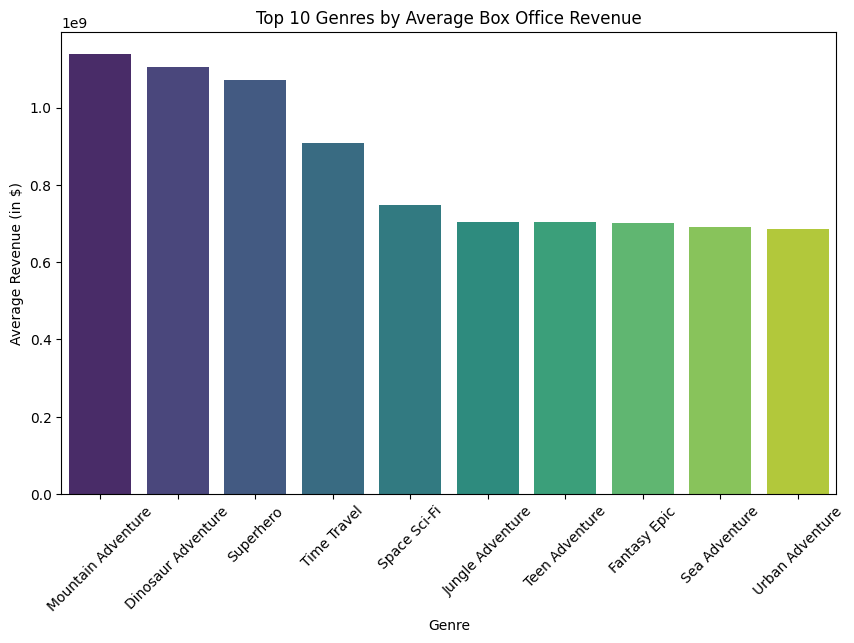

In [26]:
# Split genres into multiple rows
df_exploded = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')

# Calculate average revenue by genre
genre_revenue = df_exploded.groupby('Genre')['Box Office Revenue'].mean().sort_values(ascending=False)

print("Average Box Office Revenue by Genre:")
print(genre_revenue.head(10))  # Display top 10 genres by revenue

# Plot top 10 genres by average revenue
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_revenue.head(10).index, y=genre_revenue.head(10).values, palette='viridis')
plt.title("Top 10 Genres by Average Box Office Revenue")
plt.xlabel("Genre")
plt.ylabel("Average Revenue (in $)")
plt.xticks(rotation=45)
plt.show()

Top 10 Genres by Number of Movies:
Index(['Drama', 'Adventure', 'Epic', 'Thriller', 'Period Drama', 'Crime',
       'Tragedy', 'Action', 'Psychological Drama', 'Comedy'],
      dtype='object', name='Genre')
Genre Counts by Decade (Top 10 Genres):
Genre   Drama  Adventure  Epic  Thriller  Period Drama  Crime  Tragedy  \
Decade                                                                   
1920.0    5.0        2.0   1.0       0.0           1.0    0.0      1.0   
1930.0    4.0        1.0   1.0       1.0           1.0    1.0      0.0   
1940.0   11.0        1.0   2.0       3.0           1.0    1.0      3.0   
1950.0   18.0        4.0   3.0       7.0           3.0    5.0      3.0   
1960.0   12.0        4.0   5.0       4.0           6.0    2.0      2.0   

Genre   Action  Psychological Drama  Comedy  
Decade                                       
1920.0     2.0                  1.0     4.0  
1930.0     0.0                  0.0     3.0  
1940.0     0.0                  2.0     2.0  
1950

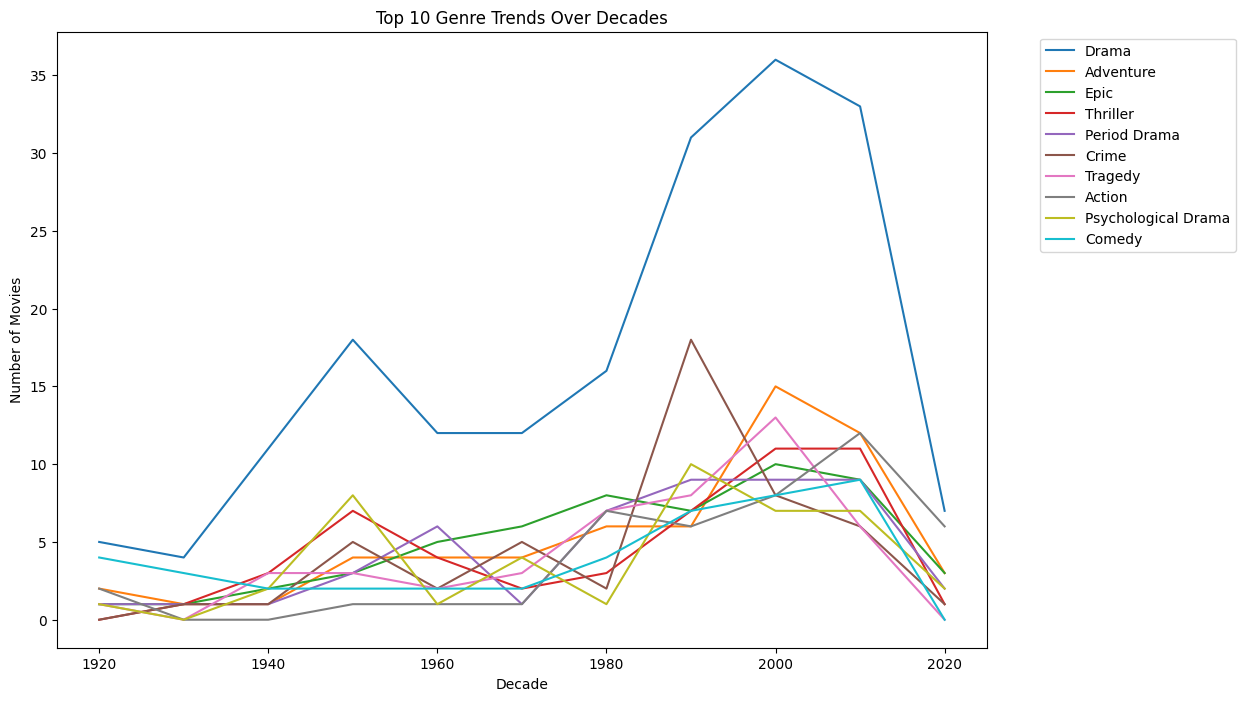

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("imdb_top_250.csv")

# Clean the data
df['Box Office Revenue'] = df['Box Office Revenue'].replace('[\$,]', '', regex=True).replace('N/A', pd.NA).astype(float)
df['IMDb Rating'] = df['IMDb Rating'].replace('N/A', pd.NA).astype(float)
df['Year'] = df['Year'].replace('N/A', pd.NA).astype(float)
df = df.dropna()

# Split genres into multiple rows
df_exploded = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')

# Create a Decade column
df_exploded['Decade'] = (df_exploded['Year'] // 10) * 10

# Count movies by genre and decade
genre_counts_by_decade = df_exploded.groupby(['Decade', 'Genre']).size().unstack().fillna(0)

# Identify the top 10 genres by total number of movies
top_10_genres = df_exploded['Genre'].value_counts().head(10).index

print("Top 10 Genres by Number of Movies:")
print(top_10_genres)

# Filter genre_counts_by_decade for top 10 genres
genre_counts_top_10 = genre_counts_by_decade[top_10_genres]

print("Genre Counts by Decade (Top 10 Genres):")
print(genre_counts_top_10.head())

# Plot genre trends over decades for top 10 genres
plt.figure(figsize=(12, 8))
for genre in genre_counts_top_10.columns:
    sns.lineplot(x=genre_counts_top_10.index, y=genre_counts_top_10[genre], label=genre)
plt.title("Top 10 Genre Trends Over Decades")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

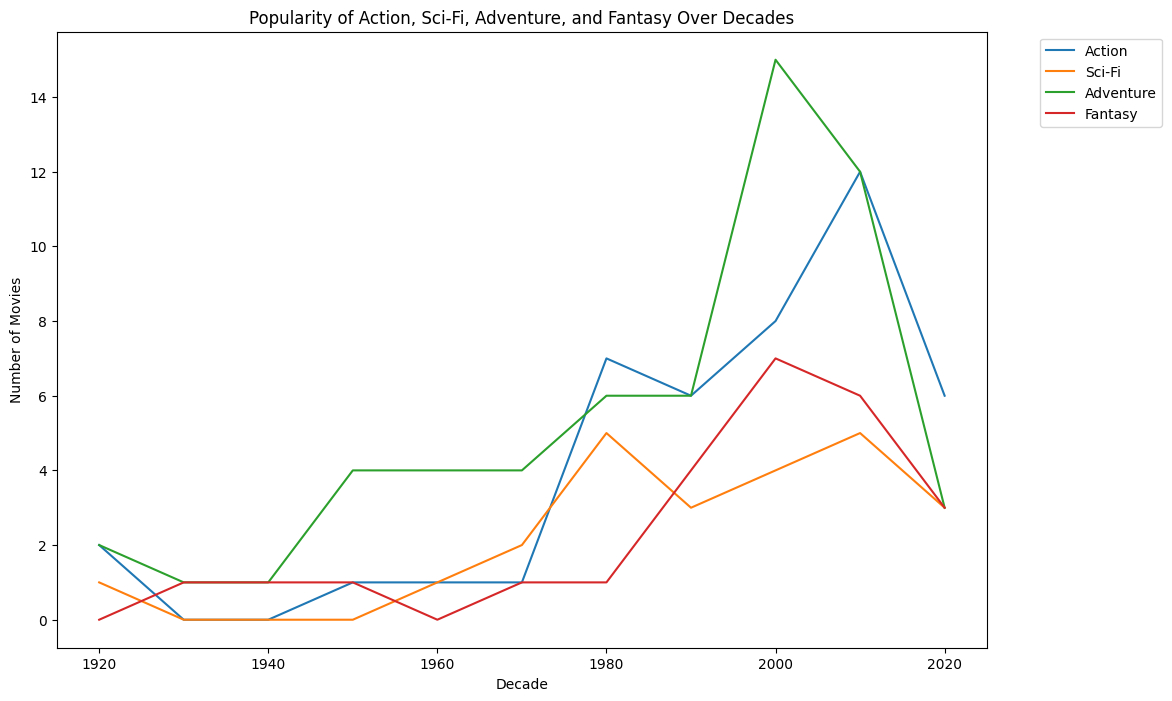

In [31]:
# Filter for specific genres
specific_genres = ['Action', 'Sci-Fi', 'Adventure', 'Fantasy']

# Plot trends for specific genres
plt.figure(figsize=(12, 8))
for genre in specific_genres:
    sns.lineplot(x=genre_counts_by_decade.index, y=genre_counts_by_decade[genre], label=genre)
plt.title("Popularity of Action, Sci-Fi, Adventure, and Fantasy Over Decades")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

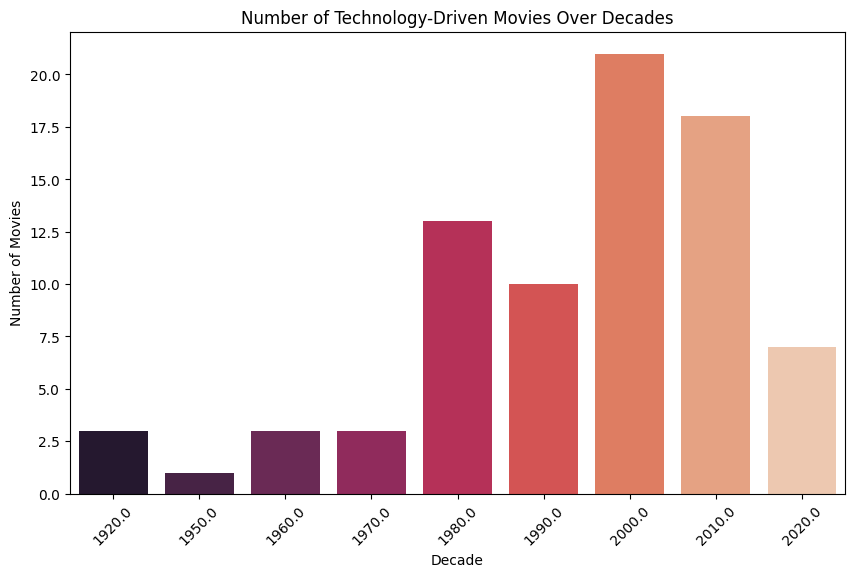

In [29]:
# Filter movies by technology (e.g., CGI, IMAX, 3D)
tech_movies = df[df['Genre'].str.contains('Action|Sci-Fi|Animation', case=False)]

# Plot the number of technology-driven movies over time
plt.figure(figsize=(10, 6))
sns.countplot(x='Decade', data=tech_movies, palette='rocket')
plt.title("Number of Technology-Driven Movies Over Decades")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()